# Imports

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import collections

# Degree Network

Create a network with a desired degree - code start taken from lecture and ChatGPT was used to help create a working version. Link to chat: https://chat.openai.com/share/6d50a46c-cb21-4e5d-9173-7e5b37c031d3


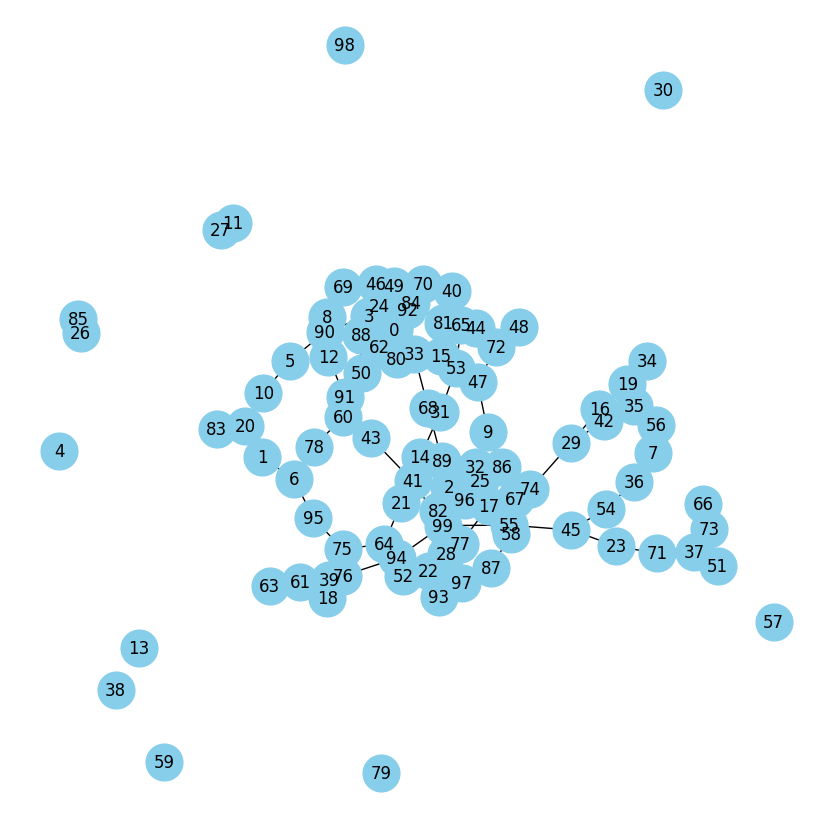

In [2]:


def configuration_A(S):
    """Configuration model with degree sequence S"""
    stubs = []
    for i in range(len(S)):
        for j in range(S[i]):
            stubs.append(i)
    n = nx.Graph()
    n.add_nodes_from(range(len(S)))  # Ensure the graph has len(S) nodes
    while len(stubs) > 1:  # Need at least 2 stubs to form an edge
        v, w = random.sample(stubs, 2)
        if v != w:  # Avoid self-loops
            n.add_edge(v, w)
            # Remove v, w from stubs
            stubs.remove(v)
            stubs.remove(w)
    return n

def configuration_B(n, P):
    """Configuration model with degree distribution P"""
    S = [1]
    while not nx.is_valid_degree_sequence_erdos_gallai(S):
        S = random.choices(population=range(len(P)), weights=P, k=n)
    return configuration_A(S)
def plot_graph(G):
    """Plot the given graph G using matplotlib"""
    plt.figure(figsize=(8, 8))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='k')
    plt.show()


def plot_degree_distribution(G, P):
    """Plot the degree distribution of graph G and compare it with distribution P"""
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # Also plot the theoretical distribution P for comparison
    theoretical_degrees = range(len(P))
    plt.plot(theoretical_degrees, [p*n for p in P], 'r-', label='Theoretical distribution')
    plt.legend()
    plt.show()



n = 100  # Number of nodes
P = [0.1, 0.2, 0.3, 0.4]  # Example distribution for demonstration


graph = configuration_B(n, P)
plot_graph(graph)

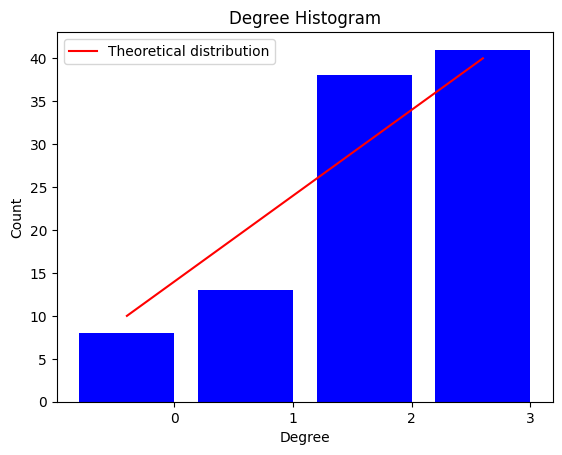

In [3]:
plot_degree_distribution(graph, P)

# Model

Fits clustering and check with r and d

In [4]:
# assistance from ChatGPT4
# https://chat.openai.com/share/decf87c3-0c7f-4cee-84aa-42475c26e25e

def model(G, c_current, cluster, allowed_error, nodes_per_round):
    c_steps = [] # Tracks changes of clustering coefficient
    #c_current = nx.average_clustering(G) # Initial clustering coefficient # commented out and fed in directly rn
    c_steps.append(c_current)
    i = 0 # Iteration counter
    cluster_bound = [cluster - allowed_error, cluster + allowed_error] # Clustering bounds

    while c_current < cluster_bound[0] or c_current > cluster_bound[1]:
        i += 1

        for node in G.nodes():
            # Access current links as a list
            current_links = list(G[node])

            if current_links:
                # Randomly selects one link to remove
                link_to_remove = random.choice(current_links)
                # Removes the selected link
                G.remove_edge(node, link_to_remove)

            # Potential new links, excluding current neighbors and the node itself
            possible_new_links = [n for n in G.nodes() if n not in current_links and n != node]

            if len(possible_new_links) > nodes_per_round:
                # Samples nodes for potential connection if there are enough candidates
                selected_nodes = random.sample(possible_new_links, nodes_per_round)
            else:
                # Otherwise, use all possible new links
                selected_nodes = possible_new_links

            c_possible = []

            for possible in selected_nodes:
                # Temporarily add the new link
                G.add_edge(node, possible)
                # Calculate new clustering coefficient and append it to the list
                c_possible.append(nx.average_clustering(G))
                # Remove the temporary link
                G.remove_edge(node, possible)

            # Select the best new link if there are possible new links
            if c_possible:
                best_node = selected_nodes[c_possible.index(max(c_possible))]
                G.add_edge(node, best_node)

        c_current = nx.average_clustering(G) # Update the clustering coefficient
        c_steps.append(c_current) # Track the clustering coefficient progression

    return G, i, c_steps


In [5]:
# check how good the model is


def analyze_graph(G):
    # Check if the graph is connected; this is required to compute the diameter
    if nx.is_connected(G):
        diameter = nx.diameter(G)
        print(f"Diameter of the graph: {diameter}")
    else:
        print("Graph is not connected; diameter of the giant component will be calculated.")
        # Find the largest connected component (giant component)
        giant_component = max(nx.connected_components(G), key=len)
        G_giant = G.subgraph(giant_component).copy()

        # Diameter of the giant component
        diameter = nx.diameter(G_giant)
        print(f"Diameter of the giant component: {diameter}")


    # Average Clustering Coefficient
    avg_clustering = nx.average_clustering(G)
    print(f"Average Clustering Coefficient: {avg_clustering}")

    # Degree Distribution
    degrees = [G.degree(n) for n in G.nodes()]
    degree_counts = np.bincount(degrees)
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(degree_counts)), degree_counts, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()


In [7]:
import pandas as pd
# Meet's stuff
Sydney = pd.read_csv("Sydney.csv")
SiouxFalls = pd.read_csv("SiouxFalls.csv")
Anaheim = pd.read_csv("Anaheim.csv")
BerlinFriedrichshain = pd.read_csv("Berlin-Friedrichshain.csv")
BerlinMitteCenter = pd.read_csv("Berlin-Mitte-Center.csv")
Barcelona = pd.read_csv("Barcelona.csv")
EasternMassachusetts = pd.read_csv("Eastern-Massachusetts.csv")
Winnipeg = pd.read_csv("Winnipeg.csv")

In [8]:
ana_net = bar_net = bf_net = bmc_net = em_net = sioux_net = syd_net = win_net = nx.Graph()

places = [Anaheim, Barcelona, BerlinFriedrichshain, BerlinMitteCenter, EasternMassachusetts, SiouxFalls, Sydney, Winnipeg]
graphs = [ana_net, bar_net, bf_net, bmc_net, em_net, sioux_net, syd_net, win_net]

for i in range(len(places)):
  for idx, row in places[i].iterrows():
    graphs[i].add_edge(row['init_node'], row['term_node'], **row.drop(['init_node', 'term_node']).to_dict())

In [9]:
# get a degree distribution from Eastern Massachusetts
em_degrees = [em_net.degree(n) for n in em_net.nodes()]
em_degree_counts = np.bincount(em_degrees)

In [10]:
# make that random model with that
em_graph = configuration_B(74, em_degree_counts)

In [11]:
em_graph_avg = nx.average_clustering(em_graph)

In [12]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.2869
em_model = model(em_graph, em_graph_avg, c, c * 0.1, 5)

In [13]:
c = 0.2869
em_model2, em_i, em_c_steps = model(em_graph, em_graph_avg, c, c * 0.1, 5)

In [14]:
em_model2

In [15]:
em_i

29

In [16]:
em_c_steps

[0.05244170244170244,
 0.21186433686433684,
 0.2073310323310323,
 0.22698900198900196,
 0.2155619905619905,
 0.17364864864864865,
 0.16969111969111975,
 0.23176748176748174,
 0.1837867087867088,
 0.21324643824643824,
 0.1621221871221871,
 0.1784212784212784,
 0.1679214929214929,
 0.14096954096954098,
 0.15137280137280137,
 0.17788112788112784,
 0.2471305721305721,
 0.21834224334224336,
 0.19985472485472486,
 0.17590090090090094,
 0.16530459030459033,
 0.20360360360360355,
 0.17096057096057088,
 0.2362875862875863,
 0.219043719043719,
 0.2078317328317328,
 0.2288541788541788,
 0.17220077220077218,
 0.2137289887289887,
 0.26340626340626333]

Diameter of the graph: 6
Average Clustering Coefficient: 0.26340626340626333


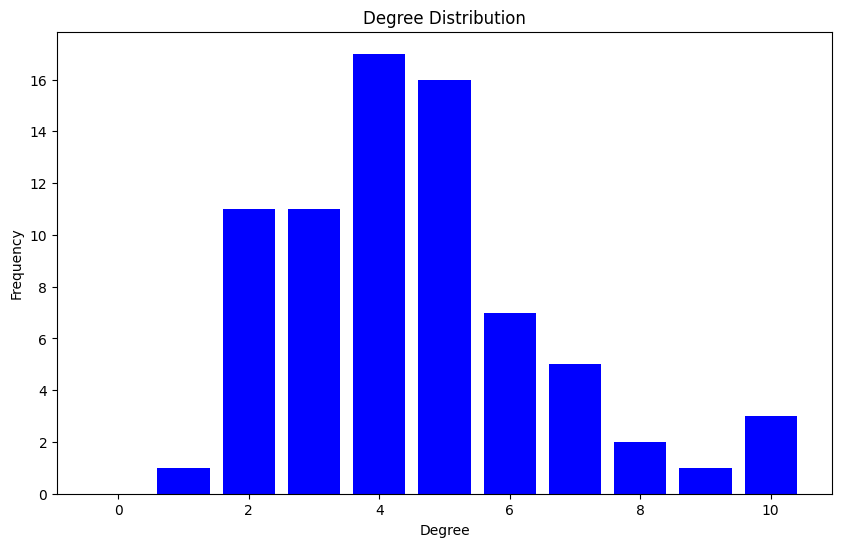

In [17]:
# compare calculated d and r values with actual values
analyze_graph(em_model2)

In [18]:
nx.degree_assortativity_coefficient(em_model2)

-0.00636085164315858

In [19]:
# get a degree distribution from Sioux Falls
sioux_degrees = [sioux_net.degree(n) for n in sioux_net.nodes()]
sioux_degree_counts = np.bincount(sioux_degrees)

In [20]:
# make that random model with that
sioux_graph = configuration_B(24, sioux_degree_counts)

In [21]:
sioux_graph_avg = nx.average_clustering(sioux_graph)

In [22]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0528
sioux_model, sioux_i, sioux_c_steps = model(sioux_graph, sioux_graph_avg, c, c * 0.1, 5)

In [ ]:
sioux_model

In [ ]:
sioux_i

In [ ]:
sioux_c_steps

In [ ]:
# compare calculated d and r values with actual values
analyze_graph(sioux_model)

In [ ]:
nx.degree_assortativity_coefficient(sioux_model)

In [ ]:
# get a degree distribution from Barcelona
bar_degrees = [bar_net.degree(n) for n in bar_net.nodes()]
bar_degree_counts = np.bincount(bar_degrees)

In [ ]:
# make that random model with that
bar_graph = configuration_B(1020, bar_degree_counts)

In [ ]:
bar_graph_avg = nx.average_clustering(bar_graph)

In [ ]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0902
bar_model = model(bar_graph, bar_graph_avg, c, c * 0.1, 5)

KeyboardInterrupt: 

In [ ]:
# get a degree distribution from Sydney
syd_degrees = [syd_net.degree(n) for n in syd_net.nodes()]
syd_degree_counts = np.bincount(syd_degrees)

In [ ]:
# make that random model with that
syd_graph = configuration_B(33837, syd_degree_counts)

In [ ]:
syd_graph_avg = nx.average_clustering(syd_graph)

In [ ]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0074
syd_model = model(syd_graph, syd_graph_avg, c, c * 0.1, 5)